In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors

import numpy as np
import xarray as xr
import pandas as pd
import os

from stompy.grid import unstructured_grid
import stompy.model.data_comparison as dc

import stompy.model.delft.dflow_model as dfm
import pesca_base

INFO:DFlowModel:DelwaqScalarBC instantiated.


In [2]:
%matplotlib notebook

In [3]:
# Load the ESA dataset:
esa_waterlevel=xr.open_dataset("../calibration/esa_compiled_waterlevel.nc")

In [4]:
# Load BML dataset:
bml_data_dir="../../data/BML data/2016/all_concatenated"

# BC1 starts later.  All other sites okay for this period.
df=pd.read_csv(os.path.join(bml_data_dir,'csv','NCK_wll_concatenated.csv'))
# UTC
df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
nck_wll=df.set_index('time')
nck_wll.head()

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,year,month,day,hour,minute,second,depth m,temp degC,Unnamed: 8
time,,,,,,,,,
2016-04-06 23:24:00,2016,4,6,23,24,0,11.657694,13.846,NaN
2016-04-06 23:27:00,2016,4,6,23,27,0,11.656686,13.269,NaN
2016-04-06 23:30:00,2016,4,6,23,30,0,11.654668,12.980,NaN
2016-04-06 23:33:00,2016,4,6,23,33,0,11.652651,12.883,NaN
2016-04-06 23:36:00,2016,4,6,23,36,0,11.648617,12.787,NaN


In [5]:
# Load QCM data, too -- code taken from pesca_base.py
qcm_pre2016=pd.read_csv("../../data/ESA_QCM/ESA_draft_PescaderoQCM_output.csv",                                                                     
                        skiprows=[0],usecols=range(7),                                                                                              
                        parse_dates=['Date (PST)'])                                                                                                 
qcm_2016_2017=pd.read_csv("../../data/ESA_QCM/ESA_draft_PescaderoQCM_output_4.28.2021.csv",                                                         
                          skiprows=[0],usecols=range(14),                                                                                           
                          parse_dates=['Date (PST)'])                                                                                               
# some extra rows in the csv                                                                                                                        
qcm_2016_2017=qcm_2016_2017[ ~qcm_2016_2017['Date (PST)'].isnull() ]                                                                                
qcm=pd.concat([qcm_pre2016,qcm_2016_2017])                                                                                                          

qcm['time']=qcm['Date (PST)'] + np.timedelta64(8,'h') # Shift to UTC.                                                        
# These are both NAVD88, converted ft=>m                                                                                                            
# Prefer the modified data when available:                                                                                                          
ocean_modified=qcm['Modified Ocean Level (feet NAVD88)']                                                                                            
# Otherwise the observed data.                                                                                                                      
ocean_level=qcm['Ocean level (feet NAVD88)']                                                                                                        
qcm['z_ocean']=0.3048 * ocean_modified.combine_first(ocean_level)                                                                                   
qcm['z_thalweg']=0.3048 * qcm['Modeled Inlet thalweg elevation (feet NAVD88)']                                                                      
# width                                                                                                                                             
qcm['w_inlet']=0.3048* qcm['Modeled Inlet Width (feet)']                                                                                            

qcm_ds=xr.Dataset.from_dataframe(qcm[ ['time','z_ocean','z_thalweg','w_inlet']].set_index('time'))                

In [77]:
# Updated test, using BML data
if 1:
    observed=xr.Dataset.from_dataframe(nck_wll)['depth m'].assign_coords(label='NCK wll')
    # model=pesca_base.PescaButano.load('run_salt_20160520-v57')    
    model=pesca_base.PescaButano.load('run_salt_20160520-v62')    

In [78]:
bcs=model.load_bcs()

Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd


In [24]:
ocean_bc=[bc for bc in bcs if bc['name']=='ocean_bc'][0]
# ocean_bc

In [10]:
from stompy.io.local import noaa_coops

mb_gauge=noaa_coops.coops_dataset_product(station=9413450,
                                          product='water_level',
                                          start_date=model.run_start,
                                          end_date=model.run_stop,
                                          cache_dir='cache')

an_gauge=noaa_coops.coops_dataset_product(station=9413878,
                                          product='predictions',
                                          interval='hilo',
                                          start_date=model.run_start,
                                          end_date=model.run_stop,
                                          cache_dir='cache')

INFO:noaa_coops:Cached   2016-05-01 00:00:00 -- 2016-06-01 00:00:00
INFO:noaa_coops:Cached   2016-06-01 00:00:00 -- 2016-07-01 00:00:00
INFO:noaa_coops:Cached   2016-05-01 00:00:00 -- 2016-06-01 00:00:00
INFO:noaa_coops:Fetching 2016-05-01 00:00:00 -- 2016-06-01 00:00:00
INFO:noaa_coops:Cached   2016-06-01 00:00:00 -- 2016-07-01 00:00:00


<IPython.core.display.Javascript object>


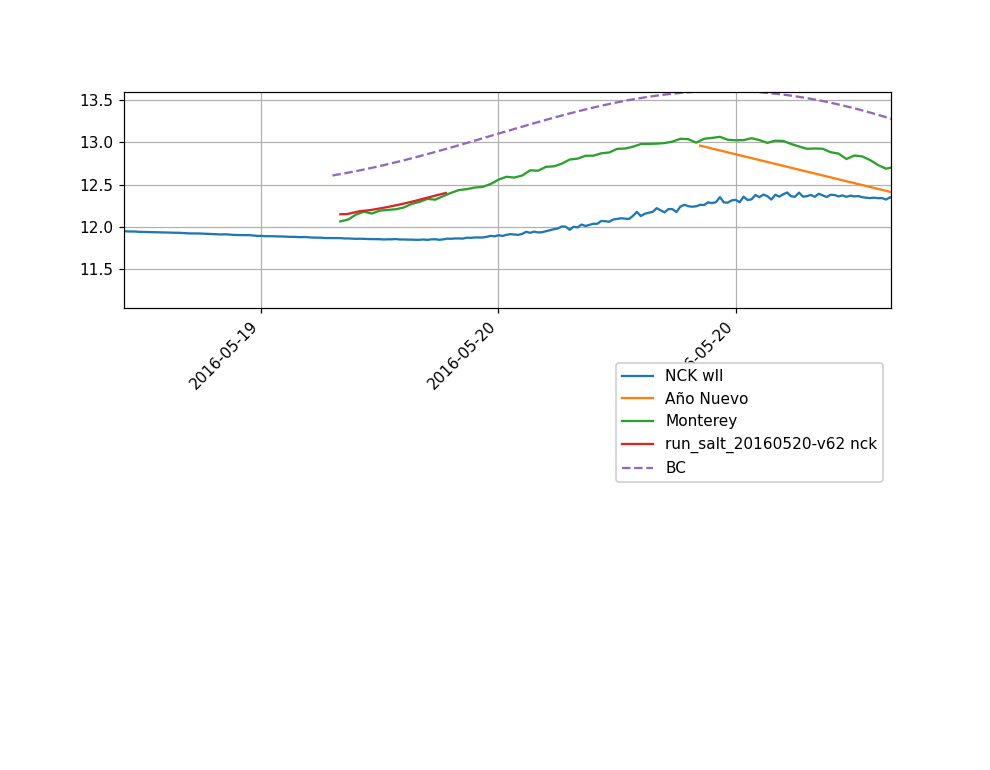

(16940.958333333332, 16941.097222222223, 10.497886219416628, 13.38061368842699)

In [79]:
import six
six.moves.reload_module(dc)

sources=[observed]

sources.append( an_gauge.predictions.isel(station=0).assign_coords(label='Año Nuevo') )
sources.append( mb_gauge.water_level.isel(station=0).assign_coords(label='Monterey'))

if 1:
    his_ds=xr.open_dataset(model.his_output())

    for model_stn in [ b'nck' ]:
        sel=np.nonzero( his_ds['station_name'].values==model_stn )[0][0]
        predicted=his_ds['waterlevel'].isel(stations=sel)
        predicted=predicted.assign_coords(label=f'{model.run_dir} {model_stn.decode()}')
        sources.append(predicted)
    
    his_ds.close()

sources.append( ocean_bc['data']['stage'].isel(node=0).assign_coords(label='BC'))

# sources[1]['label']=(),'Open mouth, no constriction'
# sources[2]['label']=(),'Open mouth, partial constriction'
fig=dc.calibration_figure_3panel(sources,trim_time=False,lowpass=False,metric_x=None)
fig.axes[2].set_visible(0)
fig.axes[1].set_visible(0)

ax=fig.axes[0]
ax.axis([16957.813032803748, 16958.72289133207, 
                  10.497886219416628, 13.38061368842699])

if 0:
    from matplotlib.ticker import FuncFormatter
    import matplotlib.dates as mdates

    hours = mdates.HourLocator(interval = 1)
    h_fmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(h_fmt)
    
plt.setp(ax.get_xticklabels(),rotation=45,ha='right')
ax.grid(1)

ax.lines[4].set_linestyle('--')

ax.legend(loc='upper right',bbox_to_anchor=[1.0,-0.22],
          framealpha=1.0)
ax.axis( xmin=his_ds.time.values[0]-np.timedelta64(1,'h'),
         xmax=his_ds.time.values[-1]+np.timedelta64(1,'h'))

In [ ]:
fig.savefig('manytides.png',dpi=200)

Salinity Comparisons
--

In [71]:
his_ds.close()

In [72]:
his_ds=xr.open_dataset(model.his_output())

In [73]:
nck_stn=np.nonzero( his_ds.station_name.values==b'nck' )[0][0]
nck_stn

7

In [31]:
model_nck_salt=his_ds.isel(stations=nck_stn).salinity
# model_nck_salt

In [115]:
bml_nck_sfc_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/NCK_sfc_mcat_concatenated.csv")
bml_nck_btm_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/NCK_btm_mcat_concatenated.csv")
bml_pc3_sfc_sond=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/PC3_sfc_sonde_concatenated.csv")
bml_pc3_btm_sond=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/PC3_btm_sonde_concatenated.csv")

bml_bc1_btm_sond=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/BC1_btm_sonde_concatenated.csv")
bml_bc1_sfc_sond=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/BC1_sfc_sonde_concatenated.csv")

bml_bc3_btm_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/BC3_btm_mcat_concatenated.csv")
bml_bc3_sfc_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/BC3_sfc_mcat_concatenated.csv")

bml_ch2_btm_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/CH2_btm_mcat_concatenated.csv")
bml_ch2_sfc_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/CH2_sfc_mcat_concatenated.csv")

for df in [bml_nck_sfc_mcat,
           bml_nck_btm_mcat,
           bml_pc3_sfc_sond,
           bml_pc3_btm_sond,
           bml_bc1_btm_sond,
           bml_bc1_sfc_sond,
           bml_bc3_btm_mcat,
           bml_bc3_sfc_mcat,
           bml_ch2_btm_mcat,
           bml_ch2_sfc_mcat,
]:
    # UTC
    df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
    df.set_index('time',inplace=True)

In [116]:
class FigSalt:
    zoom=(16960.24667031317,
          16962.483944929114,
           -0.5475896244306924,
           36.366318197905606)
    layers=['surface','bottom'] # bed layer, and near-surface layer that is mostly wet.
    colors=['tab:blue','tab:orange']
    def __init__(self,ds,his_name,bml_sfc,bml_btm):
        stn=np.nonzero( ds.station_name.values==his_name )[0][0]
        stn_da=ds['salinity'].isel(stations=stn)
        
        # Pick out top/bottom finite values.
        scal=stn_da.values

        valid=np.isfinite(scal) # time,layer
        
        fig,ax=plt.subplots(figsize=(8,4.5))
        for col,lay in zip(self.colors,self.layers):
            if lay=='surface':
                surf_idxs=valid.shape[1]-1-np.argmax(valid[:,::-1],axis=1)
                lay_scal=np.choose(surf_idxs,scal.T)
                z_label="Surface"
            elif lay=='bottom':
                bed_idxs=np.argmax(valid,axis=1)
                lay_scal=np.choose(bed_idxs,scal.T) 
                z_label="Bottom"
            else:
                lay_scal=scal[:,lay]
                z=stn_da.zcoordinate_c.isel(laydim=lay).mean().values
                z_label=f"z={z:.2f} m"
            ax.plot(stn_da.time, lay_scal,
                    label=f"Model {z_label}", color=col, ls="--")

        ax.plot(bml_sfc.index.values, bml_sfc.salinity,
                color=self.colors[0],label="BML surface")
        ax.plot(bml_btm.index.values, bml_btm.salinity, 
                color=self.colors[1],label="BML bottom")

        ax.legend(loc='upper left',bbox_to_anchor=[1.01,1.0])
        ax.axis(xmin=model_nck_salt.time.values[0],
                 xmax=model_nck_salt.time.values[-1])
        fig.subplots_adjust(right=0.73)
        fig.autofmt_xdate()
        ax.axis( self.zoom )
        name=his_name.decode()
        ax.text(0.03,0.98,name,transform=ax.transAxes,va='top')
        

<IPython.core.display.Javascript object>


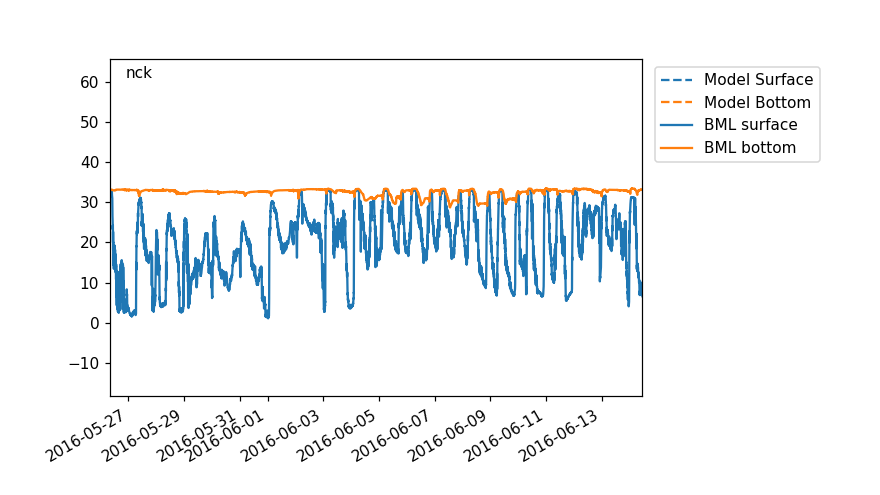

In [117]:
FigSalt(his_ds,b'nck',bml_nck_sfc_mcat,bml_nck_btm_mcat)

<IPython.core.display.Javascript object>


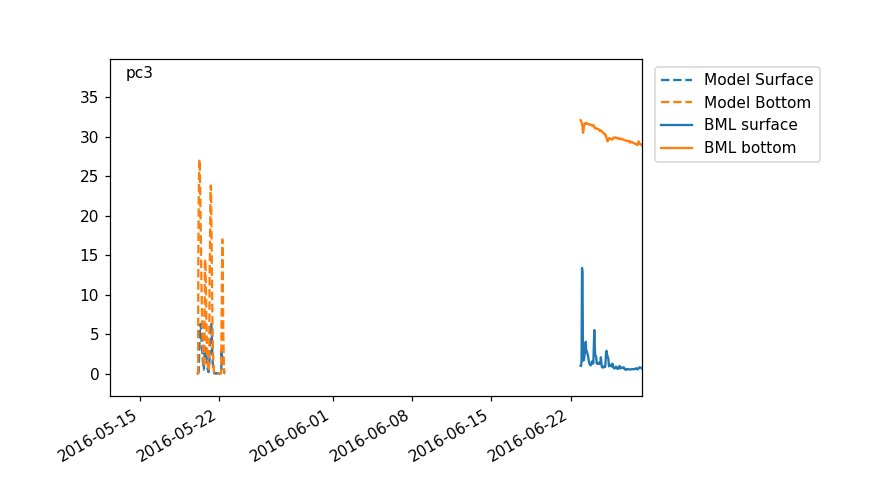

In [183]:
FigSalt(his_ds,b'pc3',bml_pc3_sfc_sond,bml_pc3_btm_sond)

<IPython.core.display.Javascript object>


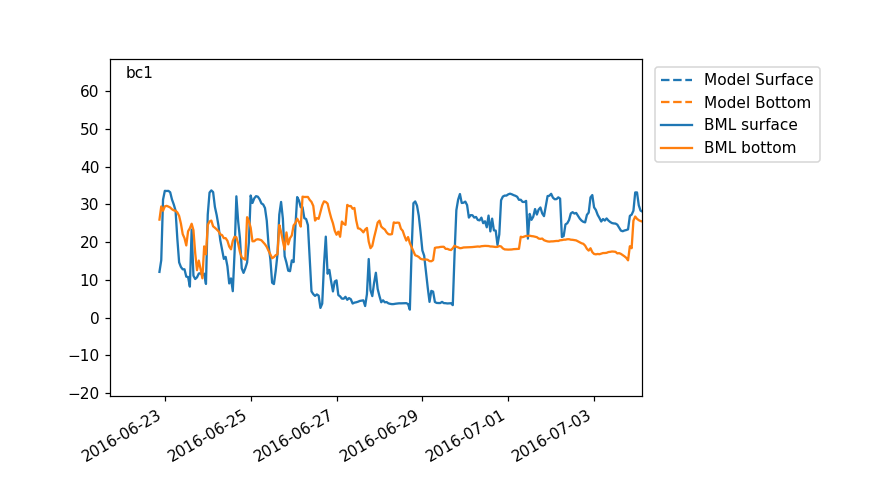

In [184]:
FigSalt(his_ds,b'bc1',bml_bc1_sfc_sond,bml_bc1_btm_sond)

<IPython.core.display.Javascript object>


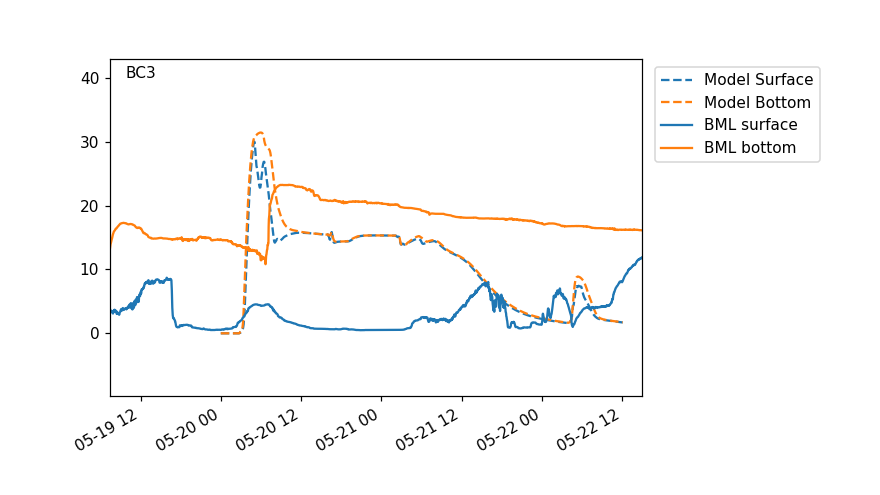

In [187]:
FigSalt(his_ds,b'BC3',bml_bc3_sfc_mcat,bml_bc3_btm_mcat)

<IPython.core.display.Javascript object>


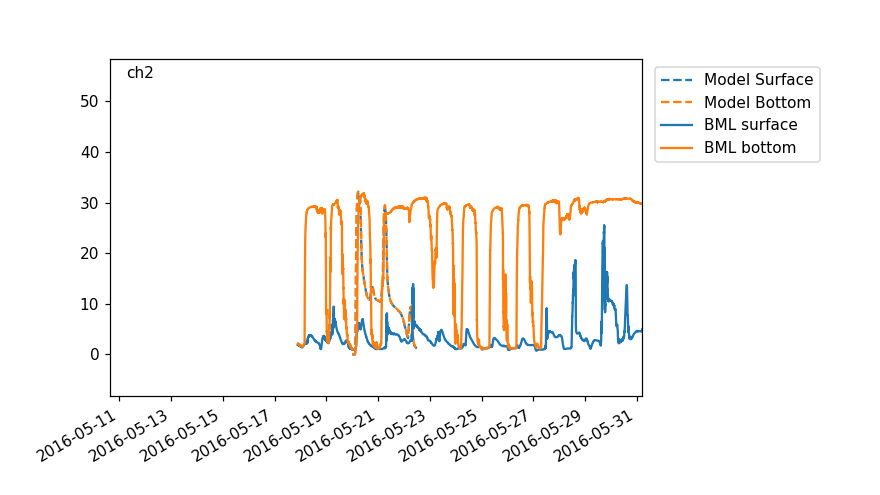

In [188]:
FigSalt(his_ds,b'ch2',bml_ch2_sfc_mcat,bml_ch2_btm_mcat)

Compare BCs
--

Seem to be fine


In [90]:
bcs=model.load_bcs()
bc_names=[bc['name'] for bc in bcs]
pesca_ck_bc=bcs[bc_names.index('pescadero_ck')]
butano_ck_bc=bcs[bc_names.index('butano_ck')]

Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd


In [91]:
# USGS gauge: 11162500
from stompy.io.local import usgs_nwis

da=pesca_ck_bc['data']
pesca_usgs=usgs_nwis.nwis_dataset(11162500,start_date=da.time.values[0],
                                  end_date=da.time.values[-1],
                                  products=[60])

INFO:usgs_nwis:Fetching 11162500_60_2016-05-01_2016-06-01.nc
INFO:usgs_nwis:Fetching 11162500_60_2016-06-01_2016-07-01.nc


In [97]:
qcm

,Date (PST),Ocean level (feet NAVD88),Observed Lagoon Level (feet NAVD88),Modeled Lagoon Level (feet NAVD88),Modeled Inlet thalweg elevation (feet NAVD88),Modeled Inlet Width (feet),Modeled Inlet Depth (feet),Modified Ocean Level (feet NAVD88),Unnamed: 8,combined fluvial,Modeled inlet flow,Modeled seepage,Modeled ET,Modeled wave overtopping,time,z_ocean,z_thalweg,w_inlet
0,2006-01-01 00:00:00,4.127246,NaN,3.608880,1.968480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-01-01 08:00:00,1.257985,0.599993,NaN
1,2006-01-01 01:00:00,3.993565,NaN,4.692469,1.968480,85.073813,2.734490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-01-01 09:00:00,1.217239,0.599993,25.930498
2,2006-01-01 02:00:00,3.679045,NaN,4.446745,1.968480,85.073813,2.495591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-01-01 10:00:00,1.121373,0.599993,25.930498
3,2006-01-01 03:00:00,3.215184,NaN,4.146940,1.968480,85.073813,2.195786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-01-01 11:00:00,0.979988,0.599993,25.930498
4,2006-01-01 04:00:00,3.192393,NaN,4.084458,1.968480,85.073813,2.117554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-01-01 12:00:00,0.973042,0.599993,25.930498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17540,2017-12-31 20:00:00,3.175814,7.569849,8.658191,9.863326,NaN,NaN,3.625085,NaN,8.222639,0.0,-0.868636,0.0,0.0,2018-01-01 04:00:00,1.104926,3.006342,NaN
17541,2017-12-31 21:00:00,4.009138,7.558488,8.659766,9.863326,NaN,NaN,4.466771,NaN,7.943000,0.0,-0.723332,0.0,0.0,2018-01-01 05:00:00,1.361472,3.006342,NaN
17542,2017-12-31 22:00:00,4.301129,7.575453,8.661341,9.863326,NaN,NaN,4.757423,NaN,7.943000,0.0,-0.667662,0.0,0.0,2018-01-01 06:00:00,1.450062,3.006342,NaN
17543,2017-12-31 23:00:00,4.163335,7.562989,8.664491,9.863326,NaN,NaN,4.625121,NaN,7.943000,0.0,-0.686407,0.0,0.0,2018-01-01 07:00:00,1.409737,3.006342,NaN


In [104]:
his_ds.close()
his_ds=xr.open_dataset(model.his_output())

In [106]:
his_ds.cross_section_name

<xarray.DataArray 'cross_section_name' (cross_section: 30)>
array([b'mouth_xs', b'n_pond_xs', b'n_ditch_xs', b'n_complex_xs',
       b'pesca_mid_xs', b'butano_lower_xs', b'pesca_lower_xs', b'pesca_bc_xs',
       b'butano_bc_xs', b'butano_mid_xs', b'mouth_xs', b'n_pond_xs',
       b'n_ditch_xs', b'n_complex_xs', b'pesca_mid_xs', b'butano_lower_xs',
       b'pesca_lower_xs', b'pesca_bc_xs', b'butano_bc_xs', b'butano_mid_xs',
       b'mouth_xs', b'n_pond_xs', b'n_ditch_xs', b'n_complex_xs',
       b'pesca_mid_xs', b'butano_lower_xs', b'pesca_lower_xs', b'pesca_bc_xs',
       b'butano_bc_xs', b'butano_mid_xs'], dtype='|S64')
Coordinates:
    cross_section_name  (cross_section) |S64 b'mouth_xs' ... b'butano_mid_xs'
Dimensions without coordinates: cross_section
Attributes:
    cf_role:    timeseries_id
    long_name:  cross section name

In [108]:
mouth=his_ds.isel(cross_section=0)
mouth

<xarray.Dataset>
Dimensions:                                  (gategens: 4, laydim: 28, laydimw: 29, nFlowElemContourPts: 4, nFlowElemWithBnd: 5301, nFlowLink: 8188, nFlowLinkPts: 2, nNetLink: 8430, nNetLinkPts: 2, station_geom_nNodes: 45, stations: 45, time: 241)
Coordinates:
    station_x_coordinate                     (stations) float64 5.526e+05 ......
    station_y_coordinate                     (stations) float64 4.124e+06 ......
    station_name                             (stations) |S64 b'pch_up' ... b'...
    zcoordinate_c                            (time, stations, laydim) float64 ...
    zcoordinate_w                            (time, stations, laydimw) float64 ...
    zcoordinate_wu                           (time, stations, laydimw) float64 ...
    cross_section_name                       |S64 b'mouth_xs'
    gategen_name                             (gategens) |S64 b'pch_gate' ... ...
  * time                                     (time) datetime64[ns] 2016-05-20...
Dimensions without coordinates: gategens, laydim, laydimw, nFlowElemContourPts, nFlowElemWithBnd, nFlowLink, nFlowLinkPts, nNetLink, nNetLinkPts, station_geom_nNodes, stations
Data variables:
    FlowElem_xcc                             (nFlowElemWithBnd) float64 5.532...
    FlowElem_ycc                             (nFlowElemWithBnd) float64 4.124...
    FlowElem_zcc                             (nFlowElemWithBnd) float64 -2.39...
    FlowElem_bac                             (nFlowElemWithBnd) float64 5.192...
    FlowElem_xzw                             (nFlowElemWithBnd) float64 5.532...
    FlowElem_yzw                             (nFlowElemWithBnd) float64 4.124...
    FlowElemContour_x                        (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElemContour_y                        (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElem_bl                              (nFlowElemWithBnd) float64 2.393...
    ElemLink                                 (nNetLink, nNetLinkPts) int32 1 ...
    FlowLink                                 (nFlowLink, nFlowLinkPts) int32 ...
    FlowLinkType                             (nFlowLink) int32 2 2 2 2 ... 2 2 2
    FlowLink_xu                              (nFlowLink) float64 5.532e+05 .....
    FlowLink_yu                              (nFlowLink) float64 4.124e+06 .....
    projected_coordinate_system              int32 -2147483647
    FlowLink_lonu                            (nFlowLink) float64 9.969e+36 .....
    FlowLink_latu                            (nFlowLink) float64 9.969e+36 .....
    FlowElemDomain                           (nFlowElemWithBnd) int32 1 1 ... 3
    FlowLinkDomain                           (nFlowLink) int32 0 0 0 0 ... 0 0 0
    FlowElemGlobalNr                         (nFlowElemWithBnd) int32 1405 .....
    station_id                               (stations) |S64 b'pch_up' ... b'...
    station_geom                             int32 -2147483647
    station_geom_node_count                  (stations) int32 1 1 1 1 ... 1 1 1
    station_geom_node_coordx                 (station_geom_nNodes) float64 5....
    station_geom_node_coordy                 (station_geom_nNodes) float64 4....
    waterlevel                               (time, stations) float64 1.498 ....
    bedlevel                                 (stations) float64 0.9477 ... 0....
    x_velocity                               (time, stations, laydim) float64 ...
    y_velocity                               (time, stations, laydim) float64 ...
    z_velocity                               (time, stations, laydim) float64 ...
    depth-averaged_x_velocity                (time, stations) float64 0.0 ......
    depth-averaged_y_velocity                (time, stations) float64 0.0 ......
    salinity                                 (time, stations, laydim) float64 ...
    taus                                     (time, stations) float64 0.0 ......
    temperature                              (time, stations, l

<IPython.core.display.Javascript object>


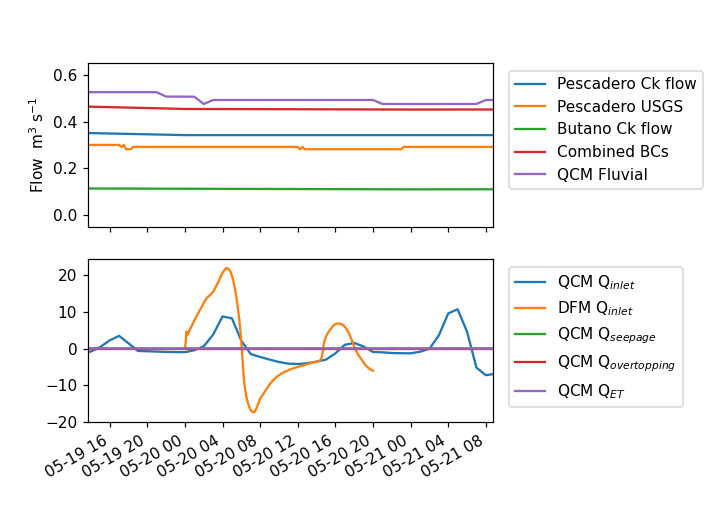

In [110]:
fig,(ax,ax_other)=plt.subplots(2,1,sharex=True)

Q=pesca_ck_bc['data']
ax.plot(Q.time, Q.flow, label="Pescadero Ck flow")

ax.plot(pesca_usgs.time,
        pesca_usgs.stream_flow_mean_daily * 0.3048**3,
        label='Pescadero USGS')

Q=butano_ck_bc['data']
ax.plot(Q.time, Q.flow, label="Butano Ck flow")

Q_comb=butano_ck_bc['data'].flow + pesca_ck_bc['data'].flow
ax.plot(Q_comb.time, Q_comb, label="Combined BCs")

ax.plot(qcm.time, qcm['combined fluvial'] * 0.3048**3,label='QCM Fluvial')
ax.legend(loc='upper left',bbox_to_anchor=[1.02,1])

fig.subplots_adjust(right=0.70)

ax.set_ylabel('Flow  m$^3$ s$^{-1}$')
ax.axis(xmin=da.time.values[0],xmax=da.time.values[-1],ymin=-0.05,ymax=0.65)

# And other fluxes:
ax_other.plot(qcm.time, qcm['Modeled inlet flow'] * 0.3048**3,label='QCM Q$_{inlet}$')
ax_other.plot(mouth.time, mouth['cross_section_discharge'],label="DFM Q$_{inlet}$" )

ax_other.plot(qcm.time, qcm['Modeled seepage'] * 0.3048**3,label='QCM Q$_{seepage}$')
ax_other.plot(qcm.time, qcm['Modeled wave overtopping'] * 0.3048**3,label='QCM Q$_{overtopping}$')
ax_other.plot(qcm.time, qcm['Modeled ET'] * 0.3048**3,label='QCM Q$_{ET}$')

ax_other.legend(loc='upper left',bbox_to_anchor=[1.02,1])
ax_other.axis(ymin=-40,ymax=40)



fig.autofmt_xdate()

<IPython.core.display.Javascript object>


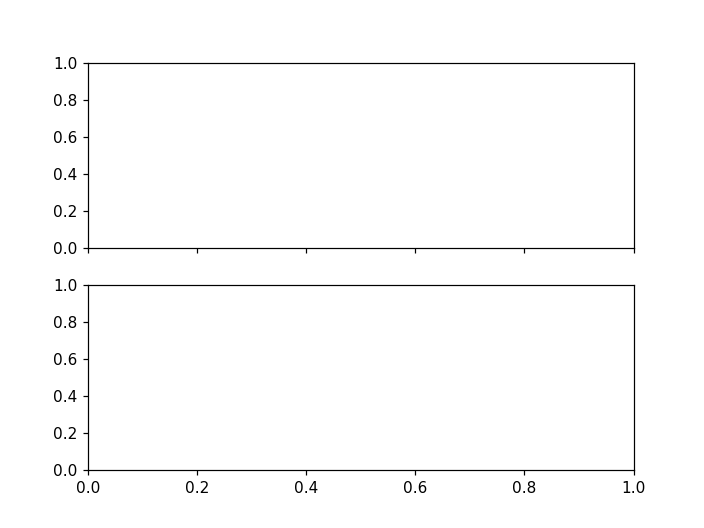

In [80]:
stn_ds=his_ds.isel(stations=7) # nck

fig,axs=plt.subplots(2,1,sharex=True)
for ax,v in zip(axs,['tke','vicww']):
    if v not in stn_ds: continue
    img=ax.imshow(stn_ds[v].values.T.clip(1e-7),aspect="auto",norm=colors.LogNorm(vmin=1e-7,vmax=1e-3),
                  cmap='turbo',origin='lower')
    plt.colorbar(img,ax=ax,label=v)


<IPython.core.display.Javascript object>


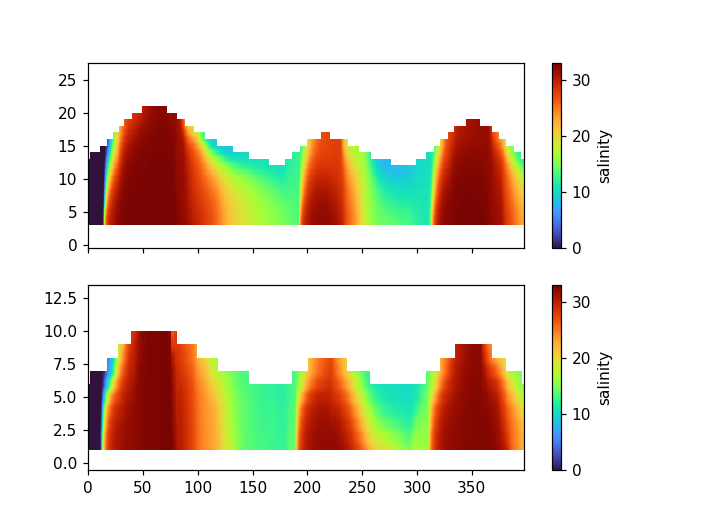

(0.0, 398.0, -0.5, 27.5)

In [111]:
# Salinity:
his_ds.close()

his_ds=xr.open_dataset(model.his_output())
fig,axs=plt.subplots(2,1,sharex=True)

img0=axs[0].imshow(his_ds.isel(stations=7)['salinity'].values.T,
                   aspect="auto", cmap='turbo', origin='lower')
plt.colorbar(img,ax=axs[0],label='salinity')

img1=axs[1].imshow(his55.isel(stations=7)['salinity'].values.T,
                   aspect="auto", cmap='turbo', origin='lower')
plt.colorbar(img1,ax=axs[1],label='salinity')

axs[0].axis(xmin=0,xmax=his_ds.time.shape[0])

<IPython.core.display.Javascript object>


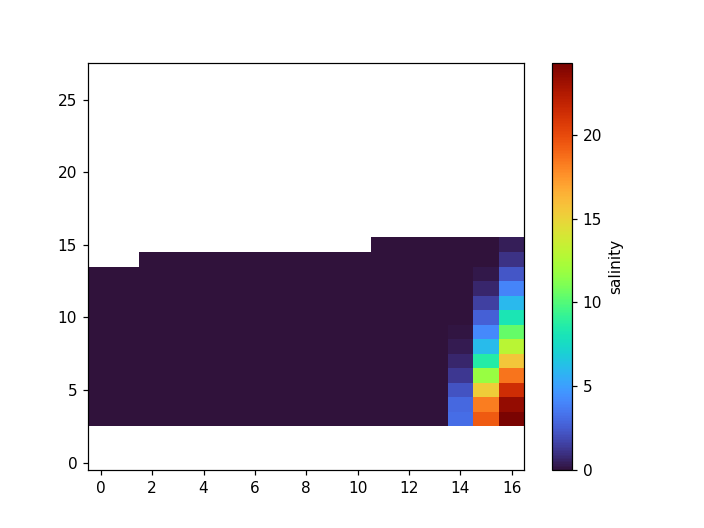

In [34]:
# Salinity:
stn_ds=his_ds.isel(stations=7) # nck
fig,ax=plt.subplots(1,1,sharex=True)

img=ax.imshow(stn_ds['salinity'].values.T,
                  aspect="auto", cmap='turbo', origin='lower')
plt.colorbar(img,ax=ax,label='salinity')


In [37]:
# For one of the longer runs, compute some max velocities over time,
# look at history output of velocity
# See if velocity is getting spiky.
his55=xr.open_dataset('run_salt_20160520-v55/DFM_OUTPUT_flowfm/flowfm_0000_his.nc')

In [49]:
stn55=his55.isel(stations=2)
stn55

<xarray.Dataset>
Dimensions:                                  (cross_section: 10, gategens: 4, laydim: 14, laydimw: 15, nFlowElemContourPts: 4, nFlowElemWithBnd: 5301, nFlowLink: 8188, nFlowLinkPts: 2, nNetLink: 8430, nNetLinkPts: 2, station_geom_nNodes: 15, time: 17713)
Coordinates:
    station_x_coordinate                     float64 5.523e+05
    station_y_coordinate                     float64 4.124e+06
    station_name                             |S64 b'lag1'
    zcoordinate_c                            (time, laydim) float64 ...
    zcoordinate_w                            (time, laydimw) float64 ...
    zcoordinate_wu                           (time, laydimw) float64 ...
    cross_section_name                       (cross_section) |S64 b'mouth_xs'...
    gategen_name                             (gategens) |S64 b'pch_gate' ... ...
  * time                                     (time) datetime64[ns] 2016-05-20...
Dimensions without coordinates: cross_section, gategens, laydim, laydimw, nFlowElemContourPts, nFlowElemWithBnd, nFlowLink, nFlowLinkPts, nNetLink, nNetLinkPts, station_geom_nNodes
Data variables:
    FlowElem_xcc                             (nFlowElemWithBnd) float64 5.532...
    FlowElem_ycc                             (nFlowElemWithBnd) float64 4.124...
    FlowElem_zcc                             (nFlowElemWithBnd) float64 -2.39...
    FlowElem_bac                             (nFlowElemWithBnd) float64 5.192...
    FlowElem_xzw                             (nFlowElemWithBnd) float64 5.532...
    FlowElem_yzw                             (nFlowElemWithBnd) float64 4.124...
    FlowElemContour_x                        (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElemContour_y                        (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElem_bl                              (nFlowElemWithBnd) float64 2.393...
    ElemLink                                 (nNetLink, nNetLinkPts) int32 1 ...
    FlowLink                                 (nFlowLink, nFlowLinkPts) int32 ...
    FlowLinkType                             (nFlowLink) int32 2 2 2 2 ... 2 2 2
    FlowLink_xu                              (nFlowLink) float64 5.532e+05 .....
    FlowLink_yu                              (nFlowLink) float64 4.124e+06 .....
    projected_coordinate_system              int32 -2147483647
    FlowLink_lonu                            (nFlowLink) float64 9.969e+36 .....
    FlowLink_latu                            (nFlowLink) float64 9.969e+36 .....
    FlowElemDomain                           (nFlowElemWithBnd) int32 1 1 ... 3
    FlowLinkDomain                           (nFlowLink) int32 0 0 0 0 ... 0 0 0
    FlowElemGlobalNr                         (nFlowElemWithBnd) int32 1405 .....
    station_id                               |S64 ...
    station_geom                             int32 -2147483647
    station_geom_node_count                  int32 ...
    station_geom_node_coordx                 (station_geom_nNodes) float64 5....
    station_geom_node_coordy                 (station_geom_nNodes) float64 4....
    waterlevel                               (time) float64 ...
    bedlevel                                 float64 ...
    x_velocity                               (time, laydim) float64 ...
    y_velocity                               (time, laydim) float64 ...
    z_velocity                               (time, laydim) float64 ...
    depth-averaged_x_velocity                (time) float64 ...
    depth-averaged_y_velocity                (time) float64 ...
    tke                                      (time, laydimw) float64 ...
    vicww                                    (time, laydimw) float64 ...
    eps                                      (time, laydimw) float64 ...
    salinity                                 (time, laydim) float64 ...
    taus                                     (time) float64 ...
    temperature                              (time, laydim) float64 ...
    density   

In [51]:
from stompy.grid import multi_ugrid
import six
six.moves.reload_module(multi_ugrid)

mu=multi_ugrid.MultiUgrid(paths="run_salt_20160520-v55/DFM_OUTPUT_flowfm/*_map.nc",
                          cleanup_dfm=True)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

In [61]:
# 3-hourly output.  Get 20 output steps to span a few tides
umags=mu['mesh2d_ucmag'].isel(time=slice(100,120)).values

umax=np.nanmax(np.abs(umags),axis=0)

<ipython-input-61-9ff9d7a8e711>:4: RuntimeWarning: All-NaN slice encountered
  umax=np.nanmax(np.abs(umags),axis=0)


In [63]:
umax=np.nanmax(umax,axis=1)

<IPython.core.display.Javascript object>


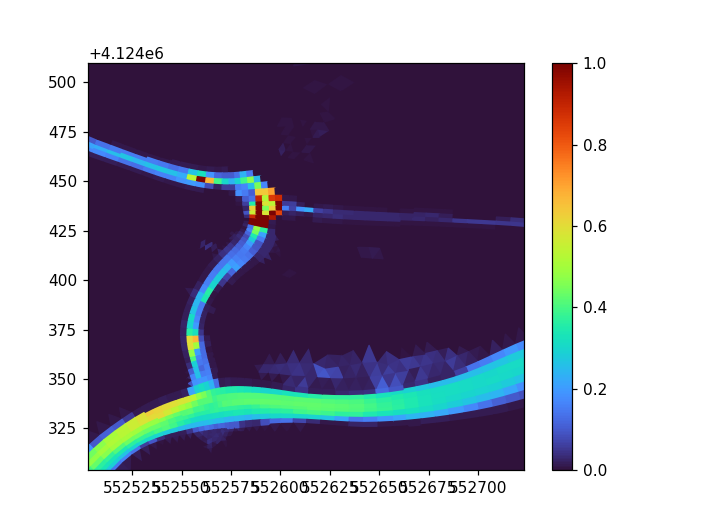

In [69]:
plt.figure()
ccoll=mu.grid.plot_cells(values=umax,cmap='turbo',clim=[0,1.0])
plt.axis('equal')
plt.axis( (551879., 552837., 4124062., 4124953.) )
plt.colorbar(ccoll)
ccoll.set_edgecolors('face')

In [67]:
plt.axis()

(551879.8671162567, 552837.0151405482, 4124062.4405242703, 4124953.9775952836)

<IPython.core.display.Javascript object>


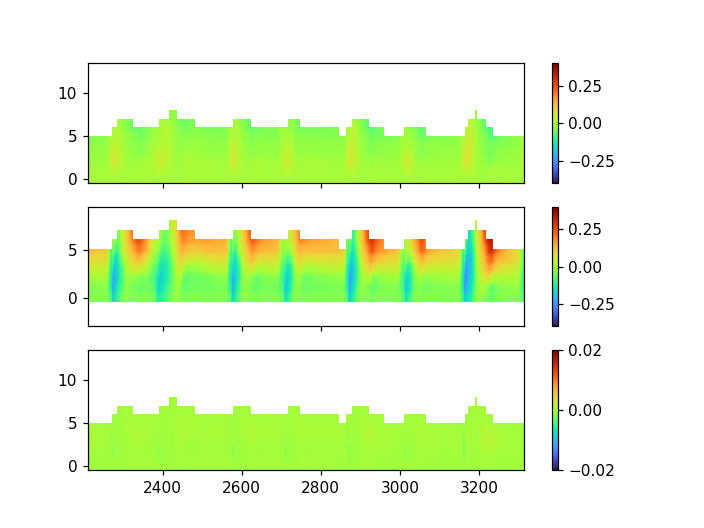

In [50]:
fig,axs=plt.subplots(3,1,sharex=True)

img0=axs[0].imshow( stn55.x_velocity.T.values, origin='lower',aspect='auto',cmap='turbo')
plt.colorbar(img0,ax=axs[0])
img1=axs[1].imshow( stn55.y_velocity.T.values, origin='lower',aspect='auto',cmap='turbo')
plt.colorbar(img1,ax=axs[1])
img2=axs[2].imshow( stn55.z_velocity.T.values, origin='lower',aspect='auto',cmap='turbo')
plt.colorbar(img2,ax=axs[2])

img0.set_clim([-0.4,0.4])
img1.set_clim([-0.4,0.4])
img2.set_clim([-0.02,0.02])
